# Bigraph Schema Basics
This tutorial demonstrates use of bigraph-viz, a visualization tool for bigraph composition schema. 
The tutorial stars with a single `store` and increases in detail as you scroll to the bottom.

See the [Bigraph-viz GitHub](https://github.com/vivarium-collective/bigraph-viz) for the source code.

## Imports and settings

In [18]:
from bigraphviz import plot_bigraph
plot_settings = {
    'remove_process_place_edges': True,
}
save_images = False
if save_images:
    plot_settings.update({
        'out_dir': 'out',
        'dpi': '250'
    })

## Stores

### Simple stores
An store can be declared in a JSON dictionary with the store's name matched to a dictionary. Leaf node values are declared by the `_value` key and types declared by the `_type` key.

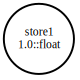

In [2]:
simple_store_spec = {
    'store1': {
        '_value': 1.0, 
        '_type': 'float',
    },
}
plot_bigraph(simple_store_spec, **plot_settings, plot_schema=True, filename='store')

### Hierarchy
A hierarchy is a place graph of nested stores. Stores can be placed within stores using JSON dictionary nesting.

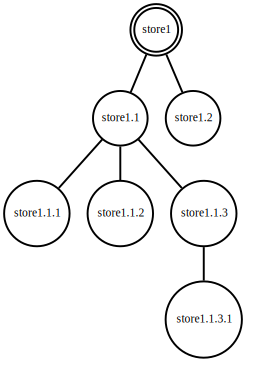

In [3]:
composite_store_spec = {
    'store1': {
        'store1.1': {
            'store1.1.1': {
                '_value': 1.1, 
                '_type': 'float',
            },
            'store1.1.2': {
                '_value': 2, 
                '_type': 'int',
            },
            'store1.1.3': {
                '_value': 0.01, 
                '_type': 'float',
                'store1.1.3.1': {
                    '_value': 0.1, 
                    '_type': 'float',
                },
            },
        },
        'store1.2': {
            '_value': 1, 
            '_type': 'int',
        },
    },
}
plot_bigraph(composite_store_spec, **plot_settings, filename='hierarchy')

## Processes

### Single process
Processes require ports, which are declared with the `_ports` key mapped to a dict that has port names matched to types.

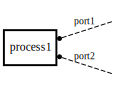

In [4]:
process_spec = {
    'process1': {
        '_ports': {
            'port1': {'_type': 'type'},
            'port2': {'_type': 'type'},
        },
    },
}
plot_bigraph(process_spec, **plot_settings, rankdir='RL', filename='process')

### Multiple processes

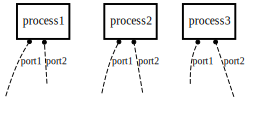

In [5]:
process_schema = {
    '_ports': {
        'port1': {'_type': 'type'},
        'port2': {'_type': 'type'}
    }
}

process_spec = {
    'process1': process_schema,
    'process2': process_schema,
    'process3': process_schema,
}
plot_bigraph(process_spec, **plot_settings, rankdir='BT', filename='multiple_processes')

## Wires
To connect a process's ports to stores, add wiring with a `_wires` key that maps port names to relative paths in the store hierarchy. The ports used by the wires need to match the ports in the schema.

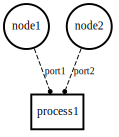

In [6]:
connected_process_spec = {
    'process1': {
        '_ports': {
            'port1': {'_type': 'type'},
            'port2': {'_type': 'type'},
        },
        '_wires': {
            'port1': 'node1',
            'port2': 'node2',
        }
    },
    'node1': {
        '_value': 1.1, '_type': 'float'
    },
    'node2': {
        '_value': 2, '_type': 'int'
    },
}
plot_bigraph(connected_process_spec, **plot_settings, filename='wires')

### Advanced wiring
**TODO**

## Composites

### Flat composite
A flat composite connects stores with multiple connected processes, without nesting.

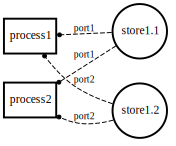

In [7]:
flat_composite_spec = {
    'store1.1': {
        '_value': 1.1, 
        '_type': 'float',
    },
    'store1.2': {
        '_value': 2, 
        '_type': 'int',
    },
    'process1': {
        '_ports': {
            'port1': {'_type': 'type'}, 
            'port2': {'_type': 'type'},
        },
        '_wires': {
            'port1': 'store1.1',
            'port2': 'store1.2',
        }
    },
    'process2': {
        '_ports': {
            'port1': {'_type': 'type'}, 
            'port2': {'_type': 'type'},
        },
        '_wires': {
            'port1': 'store1.1',
            'port2': 'store1.2',
        }
    },
}
plot_bigraph(flat_composite_spec, **plot_settings, rankdir='RL', filename='flat_composite')

### Nested composite
A nested composite has store hierarchies with multiple connected processes.

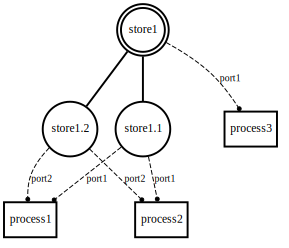

In [8]:
composite_spec = {
    'store1': {
        'store1.1': {
            '_value': 1.1, 
            '_type': 'float',
        },
        'store1.2': {
            '_value': 2, 
            '_type': 'int',
        },
        'process1': {
            '_ports': {
                'port1': {'_type': 'type'}, 
                'port2': {'_type': 'type'},
            },
            '_wires': {
                'port1': 'store1.1',
                'port2': 'store1.2',
            }
        },
        'process2': {
            '_ports': {
                'port1': {'_type': 'type'}, 
                'port2': {'_type': 'type'},
            },
            '_wires': {
                'port1': 'store1.1',
                'port2': 'store1.2',
            }
        },
    },
    'process3': {
        '_wires': {
            'port1': 'store1',
        }
    }
}
plot_bigraph(composite_spec, **plot_settings, filename='nested_composite')

### Composite process
Composite processes are processes with internal stores and internal processes, which can run as their own simulation. The composite process has schema, allowing it to connect to a super-simulation. This allows for improved distributed computation, with composite processes able to run on their own computer and syncronize to the super-simulation via message passing.

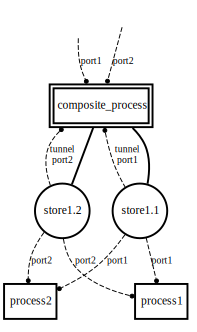

In [19]:
composite_process_spec = {
    'composite_process': {
        'store1.1': {
            '_value': 1.1, 
            '_type': 'float',
        },
        'store1.2': {
            '_value': 2, 
            '_type': 'int',
        },
        'process1': {
            '_ports': {
                'port1': 'type', 
                'port2': 'type',
            },
            '_wires': {
                'port1': 'store1.1',
                'port2': 'store1.2',
            }
        },
        'process2': {
            '_ports': {
                'port1': {'_type': 'type'}, 
                'port2': {'_type': 'type'},
            },
            '_wires': {
                'port1': 'store1.1',
                'port2': 'store1.2',
            }
        },
        '_ports': {
            'port1': {'_type': 'type'}, 
            'port2': {'_type': 'type'}, 
        },
        '_tunnels': {
            'port1': 'store1.1',
            'port2': 'store1.2',
        }
    }
}
plot_bigraph(composite_process_spec, **plot_settings, filename='composite_process')

## Orchestration

In [10]:
from bigraphviz import plot_flow, plot_multitimestep

### Multi-timestepping

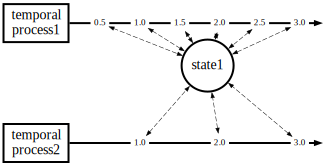

In [21]:
process_spec = {
    'temporal process2': {
        '_ports': {'port1': {'_type': 'type'}},
        '_wires': {'port1': 'state1'},
        '_sync_step': 1.0,
    },
    'temporal process1': {
        '_ports': {'port1': {'_type': 'type'}},
        '_wires': {'port1': 'state1'},
        '_sync_step': 0.5,
    },
}
plot_multitimestep(process_spec, total_time=3, filename='multitimestep')

### Flows

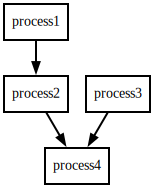

In [12]:
process_schema = {
    '_type': 'step_process',
    '_ports': {
        'port1': {'_type': 'type'},
        'port2': {'_type': 'type'}
    }
}

process_spec = {
    'step1': {
        '_depends_on': [], 
        **process_schema
    },
    'step2': {
        '_depends_on': 'process1', 
        **process_schema
    },
    'step3': {
        '_depends_on': [], 
        **process_schema
    },
    'step4': {
        '_depends_on': ['process2', 'process3'], 
        **process_schema
    },
}
plot_flow(process_spec, filename='flow')

## Examples

### Cell structure and function
Bigraphs can represent the hierarchical nesting of cellular structures, and processes represent their functions.

Writing out/cell


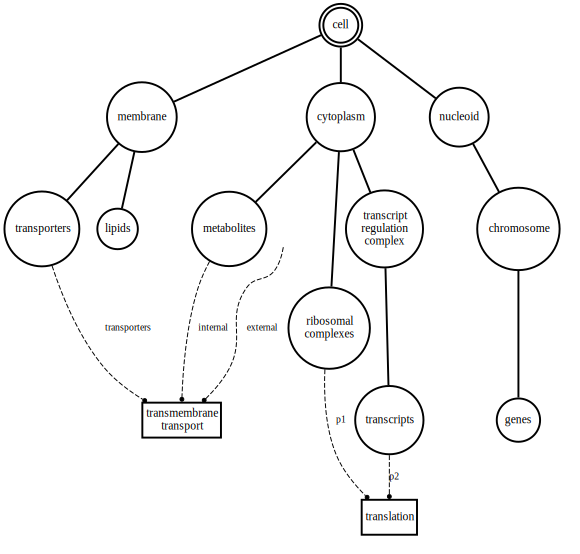

In [13]:
nested_processes = {
        'cell': {
            'membrane': {
                'transporters': {'_type': 'concentrations'},
                'lipids': {'_type': 'concentrations'},
                'transmembrane transport': {
                    '_value': {
                        '_process': 'transport URI',
                        '_config': {'parameter': 1}
                    },
                    '_wires': {
                        'transporters': 'transporters',
                        'internal': ['..', 'cytoplasm', 'metabolites']},
                    '_ports': {
                        'transporters': {'_type': 'concentrations'},
                        'internal': {'_type': 'concentrations'},
                        'external': {'_type': 'concentrations'}
                    }
                }
            },
            'cytoplasm': {
                'metabolites': {
                    '_value': 1.1,
                    '_type': 'concentrations'
                },
                'ribosomal complexes': {
                    '_value': 2.2,
                    '_type': 'concentrations'
                },
                'transcript regulation complex': {
                    '_value': 0.01,
                    '_type': 'concentrations',
                    'transcripts': {
                        '_value': 0.1,
                        '_type': 'concentrations'
                    }
                },
                'translation': {
                    '_wires': {
                        'p1': 'ribosomal complexes',
                        'p2': ['transcript regulation complex', 'transcripts']}}},
            'nucleoid': {
                'chromosome': {
                    'genes': 'sequences'
                }
            }
        }
    }
plot_bigraph(nested_processes, plot_schema=False, remove_process_place_edges=True, out_dir='out', filename='cell')

### simulation experiment
The composition schema was developed for integrative simulations, but can also be used for workflows such as simulation experiments./

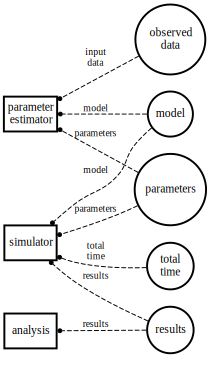

In [14]:
simulation_experiment_spec = {
    'parameter estimator': {
        '_ports': {
            'input data': {'_type': 'type'}, 
            'model': {'_type': 'SBML'}, 
            'parameters': {'_type': 'type'},},
        '_wires': {
            'input data': 'observed data',
            'model': 'model',
            'parameters': 'parameters',
        }
    },
    'simulator': {
        '_ports': {
            'model': {'_type': 'SBML'}, 
            'parameters': {'_type': 'type'},
            'total time': {'_type': 'time'},
            'results': {'_type': 'type'}
        },
        '_wires': {
            'parameters': 'parameters',
            'model': 'model',
            'total time': 'total time',
            'results': 'results',
        }
    },
    'analysis': {
        '_ports': {
            'results': {'_type': 'type'}
        },
        '_wires': {
            'results': 'results',
        }
    },
    'parameters': {},
    'model': {},
    'results': {},
    'observed data': {},
    'total time': {},
}

plot_bigraph(simulation_experiment_spec, **plot_settings, rankdir='RL', filename='simulation_experiment')